In [ ]:
#@title check GPU type
!nvidia-smi

Mon Mar 14 00:27:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
#@title Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#@title import libraries
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch import nn 
import copy

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time

from sklearn import metrics
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, roc_curve, confusion_matrix, precision_score, recall_score, auc
from sklearn.model_selection import KFold, train_test_split
torch.manual_seed(2)    # reproducible torch:2 np:3
np.random.seed(3)

%cd /content/drive/MyDrive/Proj4_DPI/scripts/model1_MolTrans/
from config import BIN_config_DBPE
from models import BIN_Interaction_Flat
from stream import BIN_Data_Encoder

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

/content/drive/MyDrive/Proj4_DPI/scripts/model1_MolTrans


In [4]:
#@title define functions
def test(data_generator, model, use_cuda):
    y_pred = []
    y_label = []
    model.eval()
    loss_accumulate = 0.0
    count = 0.0
    for i, (d, p, d_mask, p_mask, label) in enumerate(data_generator):

        label = Variable(torch.from_numpy(np.array(label)).float())
        if use_cuda:
            d = d.cuda()
            p = p.cuda()
            d_mask = d_mask.cuda()
            p_mask = p_mask.cuda()
            label = label.cuda()
        
        score = model(d, p, d_mask, p_mask)
        
        m = torch.nn.Sigmoid()
        logits = torch.squeeze(m(score))
        loss_fct = torch.nn.BCELoss()           

        loss = loss_fct(logits, label)
        
        loss_accumulate += loss
        count += 1
        
        logits = logits.detach().cpu().numpy()
        
        label_ids = label.to('cpu').numpy()
        y_label = y_label + label_ids.flatten().tolist()
        y_pred = y_pred + logits.flatten().tolist()
        
    loss = loss_accumulate/count
    
    fpr, tpr, thresholds = roc_curve(y_label, y_pred)

    precision = tpr / (tpr + fpr)

    f1 = 2 * precision * tpr / (tpr + precision + 0.00001)

    # thred_optim = thresholds[5:][np.argmax(f1[5:])]
    thred_optim = 0.5

    print("optimal threshold: " + str(thred_optim))

    # y_pred_s = [1 if i else 0 for i in (y_pred >= thred_optim)]
    y_pred_s = [1 if i>thred_optim else 0 for i in y_pred]

    auc_k = metrics.auc(fpr, tpr)
    print("AUROC:" + str(auc_k))
    print("AUPRC: "+ str(average_precision_score(y_label, y_pred)))

    cm1 = confusion_matrix(y_label, y_pred_s)
    print('Confusion Matrix : \n', cm1)
    print('Recall : ', recall_score(y_label, y_pred_s))
    print('Precision : ', precision_score(y_label, y_pred_s))

    total1=sum(sum(cm1))
    #####from confusion matrix calculate accuracy
    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    print ('Accuracy : ', accuracy1)

    sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    print('Sensitivity : ', sensitivity1 )

    specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print('Specificity : ', specificity1)

    outputs = np.asarray([1 if i else 0 for i in (np.asarray(y_pred) >= 0.5)])
    return accuracy1, roc_auc_score(y_label, y_pred), average_precision_score(y_label, y_pred), f1_score(y_label, outputs), y_pred, loss.item()


def main(use_cuda):
    config = BIN_config_DBPE()
    
    lr = config['learning_rate']
    # lr = 5e-5
    BATCH_SIZE = config['batch_size']
    train_epoch = config['train_epoch']
    accumulation_steps = config['grad_accumul_steps']
    max_d = config['max_dna_seq']
    max_p = config['max_protein_seq']
    
    print("learning rate:",lr)
    print("batch size:",BATCH_SIZE)
    print("training epoch:",train_epoch)
    print("accumulation steps:", accumulation_steps)

    loss_history = []
    loss_history_val = []
    acc_train = []
    acc_val = []
    
    model = BIN_Interaction_Flat(**config)
    
    if use_cuda:
        model = model.cuda()

    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model, dim = 0)
    elif torch.cuda.device_count() < 1:
        print("Let's use cpu!")
            
    opt = torch.optim.Adam(model.parameters(), lr = lr)
    #opt = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9)
    
    print('--- Data Preparation ---')
    
    params = {'batch_size': BATCH_SIZE,
              'shuffle': True,
              'num_workers': 6, 
              'drop_last': True}

    dataFolder = '/content/drive/MyDrive/Proj4_DPI/data/data_with_embedding/'
    # df_train = pd.read_pickle(dataFolder + '/train_loc0.pkl')
    # df_train = df_train[0:10000]
    # df_val = pd.read_pickle(dataFolder + '/val_loc0.pkl')
    # df_val = df_val[0:2000]
    # df_test = pd.read_pickle(dataFolder + '/test_loc0.pkl')
    # df = pd.read_pickle(dataFolder + '/JUNB_test.pkl')
    df = pd.read_pickle(dataFolder + '/AP2A_train.pkl')
    
    df_train, df_val = train_test_split(df, test_size=0.2)
    print("training size: ", df_train.shape[0])
    print("validation size: ", df_val.shape[0])

    training_set = BIN_Data_Encoder(np.array([i for i in range(df_train.shape[0])]), df_train.label.values, df_train, max_d, max_p)
    training_generator = data.DataLoader(training_set, **params)

    validation_set = BIN_Data_Encoder(np.array([i for i in range(df_val.shape[0])]), df_val.label.values, df_val, max_d, max_p)
    validation_generator = data.DataLoader(validation_set, **params)
    
    # testing_set = BIN_Data_Encoder(np.array([i for i in range(df_test.shape[0])]), df_test.label.values, df_test, max_d, max_p)
    # testing_generator = data.DataLoader(testing_set, **params)
    
    # early stopping
    max_auc = 0
    model_max = copy.deepcopy(model)
    
    print('--- Go for Training ---')
    torch.backends.cudnn.benchmark = True
    for epo in range(train_epoch):
        model.train()
        for i, (d, p, d_mask, p_mask, label) in enumerate(training_generator):
            
            label = Variable(torch.from_numpy(np.array(label)).float())
            if use_cuda:
                d = d.cuda()
                p = p.cuda()
                d_mask = d_mask.cuda()
                p_mask = p_mask.cuda()
                label = label.cuda()

            
            score = model(d, p, d_mask, p_mask)
            loss_fct = torch.nn.BCELoss()
            m = torch.nn.Sigmoid()
            n = torch.squeeze(m(score))
            # print(d.isnan().any())
            # print(p.isnan().any())
            # print(p)
            
            loss = loss_fct(n, label)
            loss_history.append(loss)
            loss.backward()

            if ((i+1) % accumulation_steps == 0):
              opt.step()
              opt.zero_grad()
            
            if ((i+1) % 10 == 0):
                print('Training at Epoch ' + str(epo + 1) + ' iteration ' + str(i+1) + ' with loss ' + str(loss.cpu().detach().numpy()))
            
        # every epoch test
        with torch.set_grad_enabled(False):
            accuracy, auc, auprc, f1, logits, loss = test(validation_generator, model, use_cuda)
            loss_history_val.append(loss)
            acc_val.append(accuracy)
            if auc > max_auc:
                model_max = copy.deepcopy(model)
                max_auc = auc
                # # save the model
                # save_path = './epoch' + str(epo+1) + '.pt'
                # torch.save(model.state_dict(), save_path)
                # print('Saving model to',save_path)

            print('Validation at Epoch '+ str(epo + 1) + ' , AUROC: '+ str(auc) + ' , AUPRC: ' + str(auprc) + ' , F1: '+str(f1) + ' , Val loss: '+str(loss) + ' , Accuracy: '+str(accuracy))
            accuracy, auc, auprc, f1, logits, loss = test(training_generator, model, use_cuda)
            acc_train.append(accuracy)
            print('Training at Epoch '+ str(epo + 1) + ' , AUROC: '+ str(auc) + ' , AUPRC: ' + str(auprc) + ' , F1: '+str(f1) + ' , Training loss: '+str(loss) + ' , Accuracy: '+str(accuracy))
    
    # print('--- Go for Testing ---')
    # try:
    #     with torch.set_grad_enabled(False):
    #         auc, auprc, f1, logits, loss = test(testing_generator, model_max, use_cuda)
    #         print('Testing AUROC: ' + str(auc) + ' , AUPRC: ' + str(auprc) + ' , F1: '+str(f1) + ' , Test loss: '+str(loss))
    # except:
    #     print('testing failed')
    return model_max, model, loss_history, loss_history_val, acc_train, acc_val

In [5]:
#@title run the model
# fold 1
s = time()
model_max, model_last, loss_history, loss_val, acc_train, acc_val = main(use_cuda)
e = time()
print(e-s)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
config = BIN_config_DBPE()
lr = config['learning_rate']
BATCH_SIZE = config['batch_size']
train_epoch = config['train_epoch']
accumulation_steps = config['grad_accumul_steps']
max_d = config['max_dna_seq']
max_p = config['max_protein_seq']
params = {'batch_size': BATCH_SIZE,
  'shuffle': True,
  'num_workers': 6, 
  'drop_last': True}

dataFolder = '/content/drive/MyDrive/Proj4_DPI/data/data_with_embedding/'
df_train = pd.read_pickle(dataFolder + '/train_loc0.pkl')[128:200]
training_set = BIN_Data_Encoder(np.array([i for i in range(df_train.shape[0])]), df_train.label.values, df_train, max_d, max_p)
training_generator = data.DataLoader(training_set, **params)

try:
    with torch.set_grad_enabled(False):
        auc, auprc, f1, logits, loss = test(training_generator, model_max, use_cuda)
        print('Testing AUROC: ' + str(auc) + ' , AUPRC: ' + str(auprc) + ' , F1: '+str(f1) + ' , Test loss: '+str(loss))
except:
    print('testing failed')


optimal threshold: 0.5
AUROC:0.8204365079365079
AUPRC: 0.9034588637207163
Confusion Matrix : 
 [[ 0 28]
 [ 0 36]]
Recall :  1.0
Precision :  0.5625
Accuracy :  0.5625
Sensitivity :  0.0
Specificity :  1.0
Testing AUROC: 0.8204365079365079 , AUPRC: 0.9034588637207163 , F1: 0.72 , Test loss: 3.117576837539673


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
#@title total parameters
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model_max)

+----------------------------------------------------+------------+
|                      Modules                       | Parameters |
+----------------------------------------------------+------------+
|               demb.layernorm.weight                |    768     |
|                demb.layernorm.bias                 |    768     |
|               demb.transform.weight                |   294912   |
|                demb.transform.bias                 |    384     |
|               pemb.layernorm.weight                |    384     |
|                pemb.layernorm.bias                 |    384     |
|               pemb.transform.weight                |   147456   |
|                pemb.transform.bias                 |    384     |
|   d_encoder.layer.0.attention.self.query.weight    |   147456   |
|    d_encoder.layer.0.attention.self.query.bias     |    384     |
|    d_encoder.layer.0.attention.self.key.weight     |   147456   |
|     d_encoder.layer.0.attention.self.key.bias 

20897055

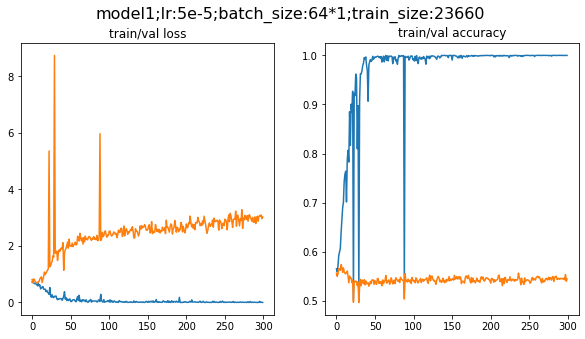

In [6]:
#@title loss plot
plt.rcParams['figure.figsize'] = [10,5]
fig,(ax1,ax2) = plt.subplots(1,2)
fig.suptitle("model1;lr:5e-5;batch_size:64*1;train_size:23660",fontsize=16)
loss_train =[ loss.cpu().detach().numpy() for loss in loss_history]


lh = list(filter(lambda x: x < 1, loss_train))
lh = [lh[i] for i in list(range(0,len(lh),369))]
# lh = list(filter(lambda x: x < 1, loss_val))
ax1.plot(lh)
ax1.set_title('train/val loss')
ax1.plot(loss_val,color='tab:orange')
ax2.plot(acc_train)
ax2.set_title('train/val accuracy')
ax2.plot(acc_val,color='tab:orange')


Text(0.5, 1.0, 'val loss')

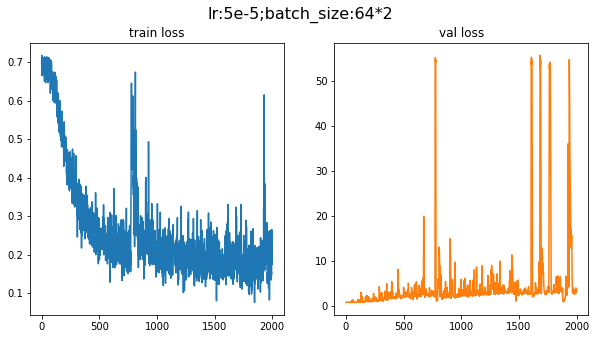

In [ ]:
plt.rcParams['figure.figsize'] = [10,5]
fig,(ax1,ax2) = plt.subplots(1,2)
fig.suptitle("lr:5e-5;batch_size:64*2",fontsize=16)

lh = list(filter(lambda x: x < 1, loss_history))
lh = [lh[i] for i in list(range(0,len(lh),3))]
# lh = list(filter(lambda x: x < 1, loss_val))
ax1.plot(lh)
ax1.set_title('train loss')
ax2.plot(loss_val,color='tab:orange')
ax2.set_title('val loss')


NameError: ignored

In [ ]:
#@title define torchtest functions
# !pip install --upgrade torchtest
# install from source because I need to make some changes to the source code
# %%bash
# git clone https://github.com/suriyadeepan/torchtest.git --quiet
class VariablesChangeException(Exception):
  pass
def assert_vars_change(model, loss_fn, optim, batch, device, params=None):
  """Make sure that the given parameters (params) DO change during training
  If parameters (params) aren't provided, check all parameters.
  Parameters
  ----------
  model : torch.nn.Module
    torch model, an instance of torch.nn.Module
  loss_fn : function
    a loss function from torch.nn.functional 
  optim : torch.optim.Optimizer
    an optimizer instance
  batch : list
    a 2 element list of inputs and labels, to be fed to the model
  params : list, optional
    list of parameters of form (name, variable)
  Raises
  ------
  VariablesChangeException
    If params do not change during training
  """

  _var_change_helper(True, model, loss_fn, optim, batch, device, params)

def _var_change_helper(vars_change, model, loss_fn, optim, batch, device, params=None): 
  """Check if given variables (params) change or not during training
  If parameters (params) aren't provided, check all parameters.
  Parameters
  ----------
  vars_change : bool
    a flag which controls the check for change or not change
  model : torch.nn.Module
    torch model, an instance of torch.nn.Module
  loss_fn : function
    a loss function from torch.nn.functional 
  optim : torch.optim.Optimizer
    an optimizer instance
  batch : list
    a 2 ele## ment list of inputs and labels, to be fed to the model
  params : list, optional
    list of parameters of form (name, variable)
  Raises
  ------
  VariablesChangeException
    if vars_change is True and params DO NOT change during training
    if vars_change is False and params DO change during training
  """

  if params is None:
    # get a list of params that are allowed to change
    params = [ np for np in model.named_parameters() if np[1].requires_grad ]

  # take a copy
  initial_params = [ (name, p.clone()) for (name, p) in params ]

  # run a training step
  _train_step(model, loss_fn, optim, batch, device)

  # check if variables have changed
  for (_, p0), (name, p1) in zip(initial_params, params):
    try:
      if vars_change:
        assert not torch.equal(p0.to(device), p1.to(device))
      else:
        assert torch.equal(p0.to(device), p1.to(device))
    except AssertionError:
      raise VariablesChangeException( # error message
          "{var_name} {msg}".format(
            var_name=name, 
            msg='did not change!' if vars_change else 'changed!' 
            )
          )

def _train_step(model, loss_fn, optim, batch, device):
  """Run a training step on model for a given batch of data
  Parameters of the model accumulate gradients and the optimizer performs
  a gradient update on the parameters
  Parameters
  ----------
  model : torch.nn.Module
    torch model, an instance of torch.nn.Module
  loss_fn : function
    a loss function from torch.nn.functional 
  optim : torch.optim.Optimizer
    an optimizer instance
  batch : list
    a 2 element list of inputs and labels, to be fed to the model
  """

  # put model in train mode
  model.train()
  model.to(device)

  #  run one forward + backward step
  # clear gradient
  optim.zero_grad()
  # inputs and targets
  d, p, d_mask, p_mask, targets = batch[0], batch[1], batch[2], batch[3], batch[4]
  # move data to DEVICE
  d = d.to(device)
  p = p.to(device)
  d_mask = d_mask.to(device)
  p_mask = p_mask.to(device)
  targets = targets.to(device)
  # targets = targets.unsqueeze(1)
  targets = Variable(torch.from_numpy(np.array(targets)).float())
  # forward
  likelihood = model(d, p, d_mask, p_mask)
  m = torch.nn.Sigmoid()
  likelihood = torch.squeeze(m(likelihood))
  print(likelihood)
  # calc loss
  loss = loss_fn(likelihood, targets)
  # backward
  loss.backward()
  # optimization step
  optim.step()

In [ ]:
#@title define configurations
config = BIN_config_DBPE()

lr = 0.01
batch_size = config['batch_size']
accumulation_steps = config['grad_accumul_steps']
print("Batch size:",batch_size)
print("The actual training batch size:",batch_size*accumulation_steps)


train_epoch = 500
max_d = config['max_dna_seq']
max_p = config['max_protein_seq']

loss_history = []

model = BIN_Interaction_Flat(**config)

if use_cuda:
  model = model.cuda()

if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model, dim = 0)
elif torch.cuda.device_count() < 1:
  print("Let's use cpu!")

opt = torch.optim.Adam(model.parameters(), lr = lr)
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("total parameters: ", pytorch_total_params)
print("trainable parameters: ", pytorch_trainable_params)


Batch size: 64
The actual training batch size: 640
Let's use cpu!
total parameters:  20897055
trainable parameters:  20897055


In [ ]:
## import data
print('--- Data Preparation ---')
params = {'batch_size': batch_size,
  'shuffle': True,
  'num_workers': 6, 
  'drop_last': True}
dataFolder = '/content/drive/MyDrive/Proj4_DPI/data/data_with_embedding/'
df_train = pd.read_pickle(dataFolder + '/train_loc0.pkl')[0:10000]
training_set = BIN_Data_Encoder(np.array([i for i in range(df_train.shape[0])]), df_train.label.values, df_train, max_d, max_p)
training_generator = data.DataLoader(training_set, **params)
df_val = pd.read_pickle(dataFolder + '/val_loc0.pkl')
df_val = df_val[1:5000]


--- Data Preparation ---


In [ ]:
df_train.label.values.sum()
# df_val.label.values.sum()


5035

In [ ]:
np.intersect1d(df_train.protein.values,df_val.protein.values)

array(['AP2A', 'AP2C', 'ARID3A', 'ATF1', 'ATF2', 'ATF3', 'BACH1',
       'BAF155', 'BAF170', 'BATF', 'BCL11A', 'BCL3', 'BCLAF1', 'BDP1',
       'BHLHE40', 'BRCA1', 'BRG1', 'CBX3', 'CCNT2', 'CEBPB', 'CEBPD',
       'CHD1', 'CHD2', 'CREB1', 'CTBP2', 'CTCF', 'CTCFL', 'E2F1', 'E2F4',
       'E2F6', 'EBF1', 'EGR1', 'ELF1', 'ELK1', 'ELK4', 'ERR1', 'ESR1',
       'ETS1', 'EZH2', 'FAM48A', 'FOS', 'FOSL1', 'FOSL2', 'FOXA1',
       'FOXA2', 'FOXM1', 'FOXP2', 'GABPA', 'GATA1', 'GATA2', 'GATA3',
       'GR', 'GTF2B', 'GTF2F1', 'GTF3C2', 'HDAC1', 'HDAC2', 'HMGN3',
       'HNF4A', 'HNF4G', 'HSF1', 'IKZF1', 'INI1', 'IRF1', 'IRF3', 'IRF4',
       'JARID1A', 'JUNB', 'JUND', 'KAP1', 'MAFF', 'MAFK', 'MAX', 'MAZ',
       'MBD4', 'MEF2A', 'MEF2C', 'MTA3', 'MXI1', 'MYBL2', 'MYC', 'NANOG',
       'NFATC1', 'NFE2', 'NFIC', 'NFYA', 'NFYB', 'NR2F2', 'NRF1', 'NRSF',
       'P300', 'PAX5', 'PBX3', 'PGC1A', 'PHF8', 'PLU1', 'PML', 'POLR2A',
       'POLR3A', 'POLR3G', 'POU2F2', 'POU5F1', 'PRDM1', 'RAD21', 'RBBP5',
 

In [ ]:
np.unique(df_val.protein.values)

array(['AP2A', 'AP2C', 'ARID3A', 'ATF1', 'ATF2', 'ATF3', 'BACH1',
       'BAF155', 'BAF170', 'BATF', 'BCL11A', 'BCL3', 'BCLAF1', 'BDP1',
       'BHLHE40', 'BRCA1', 'BRG1', 'CBX3', 'CCNT2', 'CEBPB', 'CEBPD',
       'CHD1', 'CHD2', 'CREB1', 'CTBP2', 'CTCF', 'CTCFL', 'E2F1', 'E2F4',
       'E2F6', 'EBF1', 'EGR1', 'ELF1', 'ELK1', 'ELK4', 'ERR1', 'ESR1',
       'ETS1', 'EZH2', 'FAM48A', 'FOS', 'FOSL1', 'FOSL2', 'FOXA1',
       'FOXA2', 'FOXM1', 'FOXP2', 'GABPA', 'GATA1', 'GATA2', 'GATA3',
       'GR', 'GTF2B', 'GTF2F1', 'GTF3C2', 'HDAC1', 'HDAC2', 'HDAC8',
       'HMGN3', 'HNF4A', 'HNF4G', 'HSF1', 'IKZF1', 'INI1', 'IRF1', 'IRF3',
       'IRF4', 'JARID1A', 'JUNB', 'JUND', 'KAP1', 'MAFF', 'MAFK', 'MAX',
       'MAZ', 'MBD4', 'MEF2A', 'MEF2C', 'MTA3', 'MXI1', 'MYBL2', 'MYC',
       'NANOG', 'NFATC1', 'NFE2', 'NFIC', 'NFYA', 'NFYB', 'NR2F2', 'NRF1',
       'NRSF', 'P300', 'PAX5', 'PBX3', 'PGC1A', 'PHF8', 'PLU1', 'PML',
       'POLR2A', 'POLR3A', 'POLR3G', 'POU2F2', 'POU5F1', 'PRDM1', 'RAD21',
 

In [ ]:
print('--- Go for Training ---')
torch.backends.cudnn.benchmark = True
for epo in range(train_epoch):
    model.train()
    for i, (d, p, d_mask, p_mask, label) in enumerate(training_generator):
        
        label = Variable(torch.from_numpy(np.array(label)).float())
        if use_cuda:
            d = d.cuda()
            p = p.cuda()
            d_mask = d_mask.cuda()
            p_mask = p_mask.cuda()
            label = label.cuda()

        
        score = model(d, p, d_mask, p_mask)
        loss_fct = torch.nn.BCELoss()
        m = torch.nn.Sigmoid()
        n = torch.squeeze(m(score))
        # print(d.isnan().any())
        # print(p.isnan().any())
        # print(p)
        
        loss = loss_fct(n, label)
        loss = loss / accumulation_steps
        loss_history.append(loss)
        loss.backward()

        # only updates weights after gradients are accumulated
        if (i+1) % accumulation_steps == 0:
          opt.step()
          opt.zero_grad()
          
  
        print('Training at Epoch ' + str(epo + 1) + ' iteration ' + str(i) + ' with loss ' + str(loss.cpu().detach().numpy()))
        

Streaming output truncated to the last 5000 lines.
Training at Epoch 246 iteration 20 with loss 0.07087783
Training at Epoch 246 iteration 21 with loss 0.067757346
Training at Epoch 246 iteration 22 with loss 0.06879651
Training at Epoch 246 iteration 23 with loss 0.06903021
Training at Epoch 246 iteration 24 with loss 0.06833451
Training at Epoch 246 iteration 25 with loss 0.070829764
Training at Epoch 246 iteration 26 with loss 0.06778493
Training at Epoch 246 iteration 27 with loss 0.069937214
Training at Epoch 246 iteration 28 with loss 0.06874999
Training at Epoch 246 iteration 29 with loss 0.0689032
Training at Epoch 246 iteration 30 with loss 0.07038142
Training at Epoch 247 iteration 0 with loss 0.06916329
Training at Epoch 247 iteration 1 with loss 0.06947997
Training at Epoch 247 iteration 2 with loss 0.06865624
Training at Epoch 247 iteration 3 with loss 0.06991817
Training at Epoch 247 iteration 4 with loss 0.068928495
Training at Epoch 247 iteration 5 with loss 0.07005451


In [ ]:
lh = list(filter(lambda x: x < 1, loss_history))
plt.plot(lh)

In [ ]:
#@title unit testing to check if the variables change
# from torchtest.torchtest.torchtest import assert_vars_change
config = BIN_config_DBPE()

lr = 5e-6
BATCH_SIZE = config['batch_size']
train_epoch = 20
max_d = config['max_dna_seq']
max_p = config['max_protein_seq']

loss_history = []

model = BIN_Interaction_Flat(**config)

if use_cuda:
  model = model.cuda()

if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model, dim = 0)
elif torch.cuda.device_count() < 1:
  print("Let's use cpu!")

opt = torch.optim.Adam(model.parameters(), lr = lr)
#opt = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9)






# check if variables change
assert_vars_change(
    model=model,
    loss_fn=loss_fct,
    optim=opt,
    batch=next(iter(training_generator)),
    device = "cpu")
## the result shows that variables do change, which is normal


Let's use cpu!
--- Data Preparation ---
tensor([0.5449, 0.5420, 0.5875, 0.5028, 0.5609, 0.4888, 0.5067, 0.4737, 0.4319,
        0.5757, 0.5445, 0.4892, 0.5802, 0.5591, 0.4825, 0.5260, 0.4977, 0.4802,
        0.4988, 0.4939, 0.5904, 0.5076, 0.5060, 0.5795, 0.4732, 0.5112, 0.5063,
        0.4594, 0.5629, 0.4810, 0.4885, 0.5361], grad_fn=<SqueezeBackward0>)
